In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # "0, 1" for multiple
# http://forums.fast.ai/t/tip-limiting-tensorflow-to-one-gpu/1995

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import scipy
import skimage.transform

import keras

from keras import backend as K  # set the data format as 'channels_first'

from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

from keras import applications  # VGG model

from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional, concatenate
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU, GlobalAveragePooling2D
from keras.layers.core import Flatten, Dense, Dropout, Lambda
#from keras.regularizers import l2, activity_l2, l1, activity_l1

from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
#from keras.utils.layer_utils import layer_from_config
from keras.metrics import categorical_crossentropy, categorical_accuracy

from keras.layers.convolutional import *
from keras.preprocessing import image, sequence
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.text import Tokenizer

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard  # callbacks

from glob import glob
import os
import bcolz
import ujson as json
import PIL

from scipy import ndimage
from collections import defaultdict

# import h5py

Using TensorFlow backend.


In [3]:
PATH_IMAGES = "/home/julien/tractable_images/"

## Create datasets (run only once)

In [179]:
df = pd.read_csv('./flwing_part-big_split.csv')
# There are a lot of duplicates (by image_id), we need to remove them.
df = df.drop_duplicates("image_id")

In [180]:
# We also remove all of the images which are in the csv file,
# but not in the directory.
all_images = os.listdir(PATH_IMAGES)
s = set(list(df["image_id"])) - set([x[:-4] for x in all_images])
df = df[~df["image_id"].isin(s)]

In [181]:
# Check that the csv contains the same number of images
# as the directory: 486713.
df.shape

(486713, 5)

In [182]:
df = df.drop(["b'imbag_id'", "set:"], axis=1)

In [183]:
df_flwing = df[df['flwing']==1]
df_not_flwing = df[df['flwing']==0]

In [184]:
val1 = df_flwing.sample(5000)
val2 = df_not_flwing.sample(5000)
val = pd.concat([val1, val2])
#del val1; del val2

df_flwing = df_flwing.drop(val1.index)
df_not_flwing = df_not_flwing.drop(val2.index)

In [185]:
test1 = df_flwing.sample(5000)
test2 = df_not_flwing.sample(5000)
test = pd.concat([test1, test2])
#del val1; del val2

df_flwing = df_flwing.drop(test1.index)
df_not_flwing = df_not_flwing.drop(test2.index)

In [213]:
for image in list(val1["image_id"]):
    os.rename(PATH_IMAGES+"{}.jpg".format(image),
             PATH_IMAGES+"val/flwing/{}.jpg".format(image))

for image in list(val2["image_id"]):
    os.rename(PATH_IMAGES+"{}.jpg".format(image),
             PATH_IMAGES+"val/not_flwing/{}.jpg".format(image))

In [212]:
for image in list(test1["image_id"]):
    os.rename(PATH_IMAGES+"{}.jpg".format(image),
             PATH_IMAGES+"test/flwing/{}.jpg".format(image))

for image in list(test2["image_id"]):
    os.rename(PATH_IMAGES+"{}.jpg".format(image),
             PATH_IMAGES+"test/not_flwing/{}.jpg".format(image))

In [206]:
for image in list(df_flwing["image_id"]):
    os.rename(PATH_IMAGES+"{}.jpg".format(image),
             PATH_IMAGES+"train/flwing/{}.jpg".format(image))

for image in list(df_not_flwing["image_id"]):
    os.rename(PATH_IMAGES+"{}.jpg".format(image),
             PATH_IMAGES+"train/not_flwing/{}.jpg".format(image))

### Visualization (useful cells, keep them for later)

In [7]:
# dossier avec les images.
# ./tractable_images

In [84]:
import matplotlib.pyplot as plt

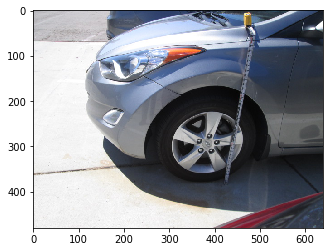

In [85]:
index = 25
image = plt.imread('./tractable_images/{}.jpg'.format(df.iloc[index]['image_id']))
plt.imshow(image)

## Classifier (resize)

In [4]:
batch_size = 64
target_size = (224,224)

In [6]:
# From
# https://jkjung-avt.github.io/keras-image-cropping/

def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    '''
    Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator
    '''
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

In [29]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        width_shift_range=0.125,
        height_shift_range=0.125,
        fill_mode='constant', cval=0.,
        shear_range=0.2,
        zoom_range=(0.7, 1.2),
        rotation_range=25
)

train_generator = train_datagen.flow_from_directory(
    directory=PATH_IMAGES+"train/",
    target_size=(480,640),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

train_crops = crop_generator(train_generator, 224)

Found 466713 images belonging to 2 classes.


In [17]:
# x_batch, y_batch = next(train_generator)

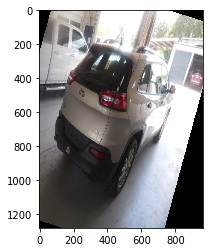

In [18]:
# plt.imshow(x_batch[0])

In [30]:
valid_datagen = ImageDataGenerator(
        rescale=1./255,
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        width_shift_range=0.125,
        height_shift_range=0.125,
        fill_mode='constant', cval=0.,
        shear_range=0.2,
        zoom_range=(0.7, 1.2),
        rotation_range=25
)

valid_generator = valid_datagen.flow_from_directory(
    directory=PATH_IMAGES+"val/",
    target_size=(480,640),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

valid_crops = crop_generator(valid_generator, 224)

Found 10000 images belonging to 2 classes.


In [57]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=PATH_IMAGES+"test/",
    target_size=(480,640),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_crops = crop_generator(test_generator, 224)

Found 10000 images belonging to 2 classes.


In [219]:
train_generator.n

466713

In [43]:
base_model = applications.VGG16(include_top=False, weights='imagenet')#, input_shape=(3,)+target_size)

i=0
for layer in base_model.layers:
    layer.trainable = False
    i = i+1
    print(i,layer.name)

1 input_4
2 block1_conv1
3 block1_conv2
4 block1_pool
5 block2_conv1
6 block2_conv2
7 block2_pool
8 block3_conv1
9 block3_conv2
10 block3_conv3
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_pool
16 block5_conv1
17 block5_conv2
18 block5_conv3
19 block5_pool


In [44]:
x = base_model.output
#x = Dense(128, activation='relu')(x)
x = GlobalAveragePooling2D()(x)
#x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='sigmoid')(x)

In [313]:
# nf=128; p=0.5
# x = base_model.output
# #print(x.shape[1:])
# #x = BatchNormalization(axis=1, input_shape=x.shape[1:])(x)
# x = Convolution2D(nf,(3,3), activation='relu', padding='same')(x)
# x = Dropout(p)(x)
# #x = BatchNormalization(axis=1, input_shape=x.shape)(x)
# x = Convolution2D(nf,(3,3), activation='relu', padding='same')(x)
# x = Dropout(p)(x)
# #x = BatchNormalization(axis=1)(x)
# x = Convolution2D(nf,(3,3), activation='relu', padding='same')(x)
# x = Dropout(p)(x)
# #x = BatchNormalization(axis=1)(x)
# x = Convolution2D(2,(3,3), padding='same')(x)
# x = Dropout(p)(x)
# predictions = GlobalAveragePooling2D()(x)
# #x = GlobalAveragePooling2D()(x)
# #predictions = Activation('sigmoid')(x)

In [45]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [46]:
class_weight = {0: 5., 1: 1.}

In [47]:
#checkpointer = ModelCheckpoint(filepath=path+'results/models/top_model_high_res_640.hdf5',
#                               verbose=1, save_best_only=True)
checkpointer = ModelCheckpoint(filepath="classifier_rc.hdf5",
                               verbose=1, save_best_only=True)    
earlystop = EarlyStopping(monitor="val_loss", patience=10)
tensorboard = TensorBoard(log_dir="rc_logs")
callbacks_list = [checkpointer, earlystop, tensorboard]

In [48]:
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=["accuracy"])


STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size  # 7292
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size  # 156
model.fit_generator(
        train_crops,
        steps_per_epoch=1823,
        epochs=100,
        #callbacks = callbacks_list,
        validation_data = valid_crops,
        validation_steps=52,
        class_weight=class_weight,
        callbacks=callbacks_list
        )

Epoch 1/100
  99/1823 [>.............................] - ETA: 1:47:05 - loss: 0.9323 - acc: 0.8037

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:790: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn("Image appears to be a malformed MPO file, it will be "


 349/1823 [====>.........................] - ETA: 1:31:51 - loss: 0.8644 - acc: 0.7933

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8589934590 bytes but only got 29023. Skipping tag 34855
  " Skipping tag %s" % (size, len(data), tag))


1008/1823 [===============>..............] - ETA: 50:05 - loss: 0.8156 - acc: 0.7922

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 16843011 bytes but only got 0. Skipping tag 64249
  " Skipping tag %s" % (size, len(data), tag))
/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 1. 
  warnings.warn(str(msg))


1623/1823 [=========================>....] - ETA: 12:13 - loss: 0.7926 - acc: 0.7985

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/Image.py:2514: DecompressionBombWarning: Image size (139201551 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


1823/1823 [==============================] - 6873s 4s/step - loss: 0.7871 - acc: 0.8000 - val_loss: 0.5399 - val_acc: 0.7272

Epoch 00001: val_loss improved from inf to 0.53989, saving model to classifier_rc.hdf5
Epoch 2/100
1291/1823 [====================>.........] - ETA: 31:55 - loss: 0.7409 - acc: 0.8115

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 6762s 4s/step - loss: 0.7025 - acc: 0.8254 - val_loss: 0.5201 - val_acc: 0.7542

Epoch 00005: val_loss did not improve from 0.48691
Epoch 6/100
1823/1823 [==============================] - 6753s 4s/step - loss: 0.7003 - acc: 0.8286 - val_loss: 0.4787 - val_acc: 0.7643

Epoch 00006: val_loss improved from 0.48691 to 0.47869, saving model to classifier_rc.hdf5
Epoch 7/100
1823/1823 [==============================] - 6752s 4s/step - loss: 0.6809 - acc: 0.8301 - val_loss: 0.4748 - val_acc: 0.7626

Epoch 00007: val_loss improved from 0.47869 to 0.47479, saving model to classifier_rc.hdf5
Epoch 8/100
1823/1823 [==============================] - 6731s 4s/step - loss: 0.6795 - acc: 0.8304 - val_loss: 0.4530 - val_acc: 0.7906

Epoch 00008: val_loss improved from 0.47479 to 0.45301, saving model to classifier_rc.hdf5
Epoch 9/100
 333/1823 [====>.........................] - ETA: 1:27:03 - loss: 0.6700 - acc: 0.8298

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 6743s 4s/step - loss: 0.6708 - acc: 0.8347 - val_loss: 0.4881 - val_acc: 0.7566

Epoch 00011: val_loss did not improve from 0.44522
Epoch 12/100
1823/1823 [==============================] - 6736s 4s/step - loss: 0.6721 - acc: 0.8343 - val_loss: 0.4594 - val_acc: 0.7765

Epoch 00012: val_loss did not improve from 0.44522
Epoch 13/100
 683/1823 [==========>...................] - ETA: 1:07:35 - loss: 0.6636 - acc: 0.8356

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 6750s 4s/step - loss: 0.6687 - acc: 0.8348 - val_loss: 0.4747 - val_acc: 0.7784

Epoch 00015: val_loss did not improve from 0.44522
Epoch 16/100
1823/1823 [==============================] - 6755s 4s/step - loss: 0.6586 - acc: 0.8390 - val_loss: 0.4873 - val_acc: 0.7617

Epoch 00016: val_loss did not improve from 0.44522
Epoch 17/100
1823/1823 [==============================] - 6750s 4s/step - loss: 0.6628 - acc: 0.8370 - val_loss: 0.4553 - val_acc: 0.7912

Epoch 00017: val_loss did not improve from 0.44522
Epoch 18/100

Epoch 00017: val_loss did not improve from 0.44522
Epoch 18/100
1823/1823 [==============================] - 6735s 4s/step - loss: 0.6629 - acc: 0.8339 - val_loss: 0.4826 - val_acc: 0.7723

Epoch 00018: val_loss did not improve from 0.44522
Epoch 19/100
1823/1823 [==============================] - 6746s 4s/step - loss: 0.6504 - acc: 0.8396 - val_loss: 0.4887 - val_acc: 0.7584

Epoch 00019: val_loss did not improve from 0.4452

In [344]:
STEP_SIZE_TRAIN, STEP_SIZE_VALID

(7292, 156)

In [49]:
import pickle
with open('./trainHistoryDict_rc.p', 'wb') as file_pi:
    pickle.dump(model.history.history, file_pi)

# model.save("./classifier_1.h5")

In [ ]:
# from keras.models import load_model

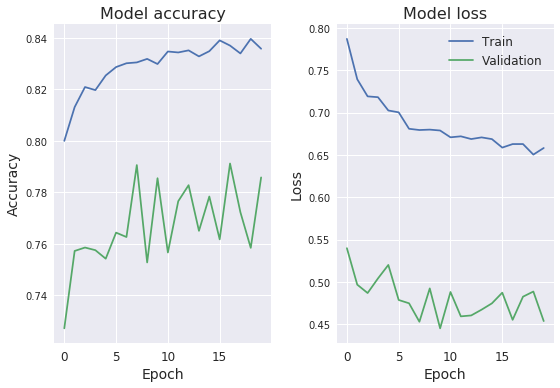

In [95]:
plt.style.use('seaborn')
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
#plt.legend(['Train', 'Validation'], loc='upper left', fontsize=12)
plt.xticks(fontsize=12)
#plt.show()
# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.savefig("./visualizations/classifier_rc_training.png", dpi=200)#bbox_inches="tight", dpi=200)

In [68]:
l_evaluate_test = [model.evaluate_generator(
        test_crops,
        steps=52,
    ) for _ in range(100)]

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:790: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn("Image appears to be a malformed MPO file, it will be "


In [69]:
l_evaluate_test

[[0.39924346964533736, 0.8164634146341463],
 [0.3607731464390571, 0.8422475961538461],
 [0.39418747505316365, 0.8245192307692307],
 [0.4106222617916945, 0.8067073170731708],
 [0.3800657374354509, 0.8338341346153846],
 [0.3867232369688841, 0.8284254807692307],
 [0.4101942654063062, 0.8073170731707318],
 [0.38182612795096177, 0.8290264423076923],
 [0.3754729984737024, 0.8350609756097561],
 [0.40854615431565505, 0.8073918269230769],
 [0.3730027082447822, 0.8323317307692307],
 [0.3848322586315434, 0.8268292682926829],
 [0.4007258008305843, 0.8076923076923077],
 [0.38371310841578704, 0.8272235576923077],
 [0.3798635287982662, 0.8359756097560975],
 [0.3913747576566843, 0.8209134615384616],
 [0.3820155354646536, 0.8275240384615384],
 [0.385117368291064, 0.8289634146341464],
 [0.38620344205544543, 0.8218149038461539],
 [0.3815386842649717, 0.8278245192307693],
 [0.37511438741916564, 0.838109756097561],
 [0.382059568969103, 0.8200120192307693],
 [0.3922520706859919, 0.8254206730769231],
 [0.389

In [73]:
l_evaluate_test2 = [model.evaluate_generator(
        test_crops,
        steps=156,
    ) for _ in range(10)]

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:790: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn("Image appears to be a malformed MPO file, it will be "


In [74]:
test_datagen_heatmaps_150 = ImageDataGenerator(rescale=1./255)

test_generator_heatmaps_150 = test_datagen_heatmaps_150.flow_from_directory(
    directory="/home/julien/crops_heatmaps/",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_crops_heatmaps_150 = crop_generator(test_generator_heatmaps_150, 224)

Found 10000 images belonging to 2 classes.


In [75]:
l_evaluate_test_heatmaps_150 = [model.evaluate_generator(
        test_crops_heatmaps_150,
        steps=156
) for _ in range(10)]

In [76]:
test_datagen_heatmaps_100 = ImageDataGenerator(rescale=1./255)

test_generator_heatmaps_100 = test_datagen_heatmaps_100.flow_from_directory(
    directory="/home/julien/crops_heatmaps_2/",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_crops_heatmaps_100 = crop_generator(test_generator_heatmaps_100, 224)

Found 10000 images belonging to 2 classes.


In [77]:
l_evaluate_test_heatmaps_100 = [model.evaluate_generator(
        test_crops_heatmaps_100,
        steps=156
) for _ in range(10)]

In [78]:
test_datagen_heatmaps_50 = ImageDataGenerator(rescale=1./255)

test_generator_heatmaps_50 = test_datagen_heatmaps_50.flow_from_directory(
    directory="/home/julien/crops_heatmaps_3/",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_crops_heatmaps_50 = crop_generator(test_generator_heatmaps_50, 224)

Found 10000 images belonging to 2 classes.


In [79]:
l_evaluate_test_heatmaps_50 = [model.evaluate_generator(
        test_crops_heatmaps_50,
        steps=156
) for _ in range(10)]

In [80]:
l_evaluate_test2

[[0.3796156879976368, 0.8286030595813204],
 [0.38581747992411136, 0.8265901771336553],
 [0.39099055950960293, 0.8240740740740741],
 [0.386785698397724, 0.8275966183574879],
 [0.3842784809893456, 0.8250805152979066],
 [0.3899495827211082, 0.8260869565217391],
 [0.38543964365734185, 0.8237721417069244],
 [0.385255296593127, 0.8272946859903382],
 [0.38738786775900735, 0.8269927536231884],
 [0.387120111696962, 0.8230676328502415]]

In [84]:
losses = [x[0] for x in l_evaluate_test2]
accuracies = [x[1] for x in l_evaluate_test2]

print("Loss")
print("Mean:", np.mean(losses))
print("Std:", np.std(losses))
print("\nAccuracy")
print("Mean:", np.mean(accuracies))
print("Std:", np.std(accuracies))

Loss
Mean: 0.38626404092459665
Std: 0.0029703673899726005

Accuracy
Mean: 0.8259158615136876
Std: 0.0017432363877231882


In [81]:
l_evaluate_test_heatmaps_150

[[0.39494755319677866, 0.8129006410256411],
 [0.39539749294087506, 0.8123993558776168],
 [0.39581626653671265, 0.812097423510467],
 [0.3941661396848215, 0.8134057971014492],
 [0.3957435233389506, 0.8123993558776168],
 [0.396099002081031, 0.8117954911433173],
 [0.3960134936031704, 0.8121980676328503],
 [0.3963175194274976, 0.8118961352657005],
 [0.3961983206959354, 0.8121980676328503],
 [0.3944204428537648, 0.813305152979066]]

In [119]:
losses_heatmaps_150 = [x[0] for x in l_evaluate_test_heatmaps_150]
accuracies_heatmaps_150 = [x[1] for x in l_evaluate_test_heatmaps_150]

print("Loss")
print("Mean:", np.mean(losses_heatmaps_150))
print("Std:", np.std(losses_heatmaps_150))
print("\nAccuracy")
print("Mean:", np.mean(accuracies_heatmaps_150))
print("Std:", np.std(accuracies_heatmaps_150))

Loss
Mean: 0.3955119754359538
Std: 0.0007208810685844491

Accuracy
Mean: 0.8124595488046575
Std: 0.0005327783696696647


In [82]:
l_evaluate_test_heatmaps_100

[[0.3432177075017721, 0.842948717948718],
 [0.3441606820973413, 0.8421900161030595],
 [0.34438043088920645, 0.8422906602254429],
 [0.3438257659978913, 0.8427938808373591],
 [0.3440601904899026, 0.8420893719806763],
 [0.3441684963526549, 0.8422906602254429],
 [0.34447592655241777, 0.8421900161030595],
 [0.34453946510374833, 0.8420893719806763],
 [0.344178115160185, 0.8424919484702094],
 [0.34184708586637524, 0.8435990338164251]]

In [120]:
losses_heatmaps_100 = [x[0] for x in l_evaluate_test_heatmaps_100]
accuracies_heatmaps_100 = [x[1] for x in l_evaluate_test_heatmaps_100]

print("Loss")
print("Mean:", np.mean(losses_heatmaps_100))
print("Std:", np.std(losses_heatmaps_100))
print("\nAccuracy")
print("Mean:", np.mean(accuracies_heatmaps_100))
print("Std:", np.std(accuracies_heatmaps_100))

Loss
Mean: 0.3438853866011495
Std: 0.000767973306868302

Accuracy
Mean: 0.8424973677691069
Std: 0.0004596348191887795


In [83]:
l_evaluate_test_heatmaps_50

[[0.3768891950066273, 0.8283253205128205],
 [0.377948512153733, 0.8275966183574879],
 [0.3780914789332668, 0.8276972624798712],
 [0.37738089318628665, 0.8278985507246377],
 [0.37768571652268057, 0.8275966183574879],
 [0.3777177362146393, 0.8275966183574879],
 [0.37847193192552636, 0.8272946859903382],
 [0.37840079287016065, 0.8273953301127214],
 [0.3772213773355008, 0.8282004830917874],
 [0.3756083122870004, 0.8290056360708534]]

In [121]:
losses_heatmaps_50 = [x[0] for x in l_evaluate_test_heatmaps_50]
accuracies_heatmaps_50 = [x[1] for x in l_evaluate_test_heatmaps_50]

print("Loss")
print("Mean:", np.mean(losses_heatmaps_50))
print("Std:", np.std(losses_heatmaps_50))
print("\nAccuracy")
print("Mean:", np.mean(accuracies_heatmaps_50))
print("Std:", np.std(accuracies_heatmaps_50))

Loss
Mean: 0.3775415946435422
Std: 0.0008009413618530624

Accuracy
Mean: 0.8278607124055494
Std: 0.0004915797197196818


In [96]:
test_datagen_frcnn = ImageDataGenerator(rescale=1./255)

test_generator_frcnn = test_datagen_frcnn.flow_from_directory(
    directory="/home/julien/crops_frcnn/",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_crops_frcnn = crop_generator(test_generator_frcnn, 224)

Found 10000 images belonging to 2 classes.


In [97]:
l_evaluate_test_frcnn = [model.evaluate_generator(
        test_crops_frcnn,
        steps=156
) for _ in range(10)]

In [98]:
l_evaluate_test_frcnn

[[0.3811821637627406, 0.8226161858974359],
 [0.3818777411840196, 0.822463768115942],
 [0.38239519185298115, 0.822061191626409],
 [0.3814839212982743, 0.822463768115942],
 [0.38205529391861576, 0.822061191626409],
 [0.3825373086184503, 0.8218599033816425],
 [0.382419440097471, 0.8218599033816425],
 [0.3826513989152156, 0.8217592592592593],
 [0.3818686916440389, 0.8222624798711755],
 [0.3804056346896382, 0.8230676328502415]]

In [122]:
losses_frcnn = [x[0] for x in l_evaluate_test_frcnn]
accuracies_frcnn = [x[1] for x in l_evaluate_test_frcnn]

print("Loss")
print("Mean:", np.mean(losses_frcnn))
print("Std:", np.std(losses_frcnn))
print("\nAccuracy")
print("Mean:", np.mean(accuracies_frcnn))
print("Std:", np.std(accuracies_frcnn))

Loss
Mean: 0.38188767859814454
Std: 0.0006656881643222366

Accuracy
Mean: 0.82224752841261
Std: 0.0003886615861660281


In [99]:
from scipy import stats

In [105]:
# 0 for loss, 1 for accruracy
t, p = stats.ttest_ind([x[1] for x in l_evaluate_test2], 
                       [x[1] for x in l_evaluate_test_frcnn],
                       equal_var=False)
t, p

(6.161683397842524, 0.00011168836149976237)

In [106]:
t, p = stats.ttest_ind([x[1] for x in l_evaluate_test2], 
                       [x[1] for x in l_evaluate_test_heatmaps_100],
                       equal_var=False)
t, p

(-27.592711609214625, 5.942114543770914e-11)

In [107]:
np.var(l_evaluate_test2), np.var(l_evaluate_test_heatmaps_100)

(0.04832936181459299, 0.06215387746464242)

In [112]:
t, p = stats.ttest_ind([x[1] for x in l_evaluate_test2], 
                       [x[1] for x in l_evaluate_test_heatmaps_50],
                       equal_var=False)
t, p

(-3.221335611280772, 0.00869536460618242)

In [110]:
np.var(l_evaluate_test_heatmaps_50)

0.0506972685343311

In [115]:
np.mean([x[1] for x in l_evaluate_test2]) - np.mean([x[1] for x in l_evaluate_test_heatmaps_50])

-0.0019448508918618046

In [116]:
np.std([x[1] for x in l_evaluate_test2]) - np.std([x[1] for x in l_evaluate_test_heatmaps_50])

0.0012516566680035065

In [117]:
np.mean([x[1] for x in l_evaluate_test2]) - np.mean([x[1] for x in l_evaluate_test_frcnn])

0.0036683331010776143

In [118]:
np.std([x[1] for x in l_evaluate_test2]) - np.std([x[1] for x in l_evaluate_test_frcnn])

0.0013545748015571602

In [ ]:
np.sqrt(np.var())